# TP 3.1 — Correction : Prévision de séries temporelles

Ce notebook propose une solution guidée pour la partie prévision du TP. Nous y comparons :
- un RNN simple codé à partir des équations du cours ;
- un LSTM manuel reconstruit avec `Linear` et `sigmoid/tanh`.

Les modèles ingèrent une fenêtre $x_{-H}, \dots, x_{-1}$ composée du doublet `[jour_de_l'année, température_normalisée]` et prédisent $x_0$. Nous monitorons l'entraînement avec teacher forcing (utilisation de la température réelle dans la fenêtre) puis analysons le comportement en déroulé libre (prédiction itérative).


In [1]:
from pathlib import Path
import random

import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Utilisation du périphérique : {device}')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Utilisation du périphérique : cuda


## 1. Chargement des données train / test

In [2]:
data_root = Path('data')
train_path = data_root / 'DailyDelhiClimateTrain.csv'
test_path = data_root / 'DailyDelhiClimateTest.csv'
assert train_path.exists() and test_path.exists()

df_train = (pd.read_csv(train_path, parse_dates=['date'])
              .set_index('date')
              .sort_index())

df_test = (pd.read_csv(test_path, parse_dates=['date'])
             .set_index('date')
             .sort_index())

df_train.head()


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
df_test.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [4]:
print('Train:')
display(df_train.describe().T)
print('Test:')
display(df_test.describe().T)


Train:


,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


Test:


,count,mean,std,min,25%,50%,75%,max
meantemp,114.0,21.713079,6.360072,11.0000,16.437198,19.875000,27.705357,34.500000
humidity,114.0,56.258362,19.068083,17.7500,39.625000,57.750000,71.902778,95.833333
wind_speed,114.0,8.143924,3.588049,1.3875,5.563542,8.069444,10.068750,19.314286
meanpressure,114.0,1004.035090,89.474692,59.0000,1007.437500,1012.739316,1016.739583,1022.809524


In [5]:
print('Valeurs manquantes (train):')
print(df_train.isna().sum())
print('Valeurs manquantes (test):')
print(df_test.isna().sum())


Valeurs manquantes (train):
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64
Valeurs manquantes (test):
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


## 2. Préparation : interpolation, encodage du jour et normalisation de la température

- `jour_de_l'année` est encodé entre [-1, 1] pour conserver un repère saisonnier comme demandé ;
- `meantemp` est standardisée à partir des données d'entraînement puis la même échelle est appliquée au test.


In [6]:
def add_day_feature(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    day_of_year = out.index.dayofyear.to_numpy()
    out['day_fraction'] = 2.0 * (day_of_year - 1) / 365.0 - 1.0
    return out

train_proc = add_day_feature(df_train).interpolate(method='time')
test_proc = add_day_feature(df_test).interpolate(method='time')

temp_scaler = StandardScaler()
train_temp_norm = temp_scaler.fit_transform(train_proc[['meantemp']]).ravel()
test_temp_norm = temp_scaler.transform(test_proc[['meantemp']]).ravel()

train_features = np.stack([train_proc['day_fraction'].to_numpy(), train_temp_norm], axis=-1).astype(np.float32)
test_features = np.stack([test_proc['day_fraction'].to_numpy(), test_temp_norm], axis=-1).astype(np.float32)

print('Features train :', train_features.shape)
print('Features test  :', test_features.shape)


Features train : (1462, 2)
Features test  : (114, 2)


In [7]:
def denormalize_temp(values: np.ndarray) -> np.ndarray:
    return temp_scaler.inverse_transform(values.reshape(-1, 1)).ravel()

train_days = train_proc.index
test_days = test_proc.index


## 3. Jeu de données glissant et DataLoaders

Chaque échantillon correspond à une fenêtre d'historique `HISTORY` suivie de la température cible du jour suivant.


In [8]:
HISTORY = 30

class WindowDataset(Dataset):
    def __init__(self, features: np.ndarray, targets: np.ndarray, history: int):
        assert len(features) == len(targets)
        if len(features) <= history:
            raise ValueError('Le nombre total de points doit excéder HISTORY.')
        self.features = features
        self.targets = targets
        self.history = history

    def __len__(self) -> int:
        return len(self.targets) - self.history

    def __getitem__(self, idx: int):
        window = self.features[idx: idx + self.history]
        target = self.targets[idx + self.history]
        target_day = self.features[idx + self.history, 0]
        return (torch.from_numpy(window),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(target_day, dtype=torch.float32))

train_dataset = WindowDataset(train_features, train_temp_norm, HISTORY)
test_dataset = WindowDataset(test_features, test_temp_norm, HISTORY)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

sample_window, sample_target, sample_day = train_dataset[0]
print('Fenêtre exemple :', sample_window.shape)
print('Cible normalisée :', sample_target.item())
print('Jour normalisé   :', sample_day.item())


Fenêtre exemple : torch.Size([30, 2])
Cible normalisée : -1.2654560804367065
Jour normalisé   : -0.835616409778595


## 4. Cellule RNN simple (équations du cours)

In [9]:
class SimpleRNNCell(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, x_t: torch.Tensor, h_prev: torch.Tensor) -> torch.Tensor:
        return torch.tanh(self.input_layer(x_t) + self.hidden_layer(h_prev))


## 5. Cellule LSTM manuelle (portes implémentées à la main)

In [10]:
class ManualLSTMCell(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gate_layer = nn.Linear(input_dim + hidden_dim, 4 * hidden_dim)

    def forward(self, x_t: torch.Tensor, state: tuple[torch.Tensor, torch.Tensor]):
        h_prev, c_prev = state
        combined = torch.cat([x_t, h_prev], dim=-1)
        gates = self.gate_layer(combined)
        i, f, g, o = gates.chunk(4, dim=-1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        gate_dict = {"i": i, "f": f, "o": o, "g": g, "c": c}
        return h, c, gate_dict


## 6. Modèle autoregressif (sortie unique)

In [11]:
class AutoregressiveForecaster(nn.Module):
    def __init__(self, cell_type: str, input_dim: int, hidden_dim: int):
        super().__init__()
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('cell_type doit être "rnn" ou "lstm".')
        self.cell_type = cell_type
        self.hidden_dim = hidden_dim
        if cell_type == 'rnn':
            self.cell = SimpleRNNCell(input_dim, hidden_dim)
        else:
            self.cell = ManualLSTMCell(input_dim, hidden_dim)
        self.readout = nn.Linear(hidden_dim, 1)

    def _forward(self, inputs: torch.Tensor, collect_gates: bool = False):
        batch_size, seq_len, _ = inputs.shape
        device = inputs.device
        gate_history = [] if (collect_gates and self.cell_type == 'lstm') else None

        if self.cell_type == 'lstm':
            h = torch.zeros(batch_size, self.hidden_dim, device=device)
            c = torch.zeros(batch_size, self.hidden_dim, device=device)
        else:
            h = torch.zeros(batch_size, self.hidden_dim, device=device)
            c = None

        for step in range(seq_len):
            x_t = inputs[:, step, :]
            if self.cell_type == 'lstm':
                h, c, gates = self.cell(x_t, (h, c))
                if gate_history is not None:
                    gate_history.append({k: v.detach().cpu() for k, v in gates.items()})
            else:
                h = self.cell(x_t, h)

        output = self.readout(h)
        return output, gate_history

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        out, _ = self._forward(inputs, collect_gates=False)
        return out

    def forward_with_gates(self, inputs: torch.Tensor):
        return self._forward(inputs, collect_gates=True)


## 7. Boucles d'entraînement / évaluation

In [12]:
def evaluate_loader(model: nn.Module, loader: DataLoader, device: torch.device) -> tuple[np.ndarray, np.ndarray]:
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for windows, temp, _ in loader:
            windows = windows.to(device)
            temp = temp.to(device)
            outputs = model(windows).squeeze(-1)
            preds.append(outputs.detach().cpu())
            targets.append(temp.detach().cpu())
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    return preds, targets


def mae_rmse(preds_c: np.ndarray, targets_c: np.ndarray) -> tuple[float, float]:
    mae = float(np.mean(np.abs(preds_c - targets_c)))
    rmse = float(np.sqrt(np.mean((preds_c - targets_c) ** 2)))
    return mae, rmse


def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                epochs: int,
                lr: float,
                device: torch.device) -> dict[str, list[float]]:
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'val_rmse': []}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for windows, target, _ in train_loader:
            windows = windows.to(device)
            target = target.to(device)
            preds = model(windows).squeeze(-1)
            loss = criterion(preds, target)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * windows.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        val_preds, val_targets = evaluate_loader(model, val_loader, device)
        val_loss = float(np.mean((val_preds - val_targets) ** 2))
        val_preds_c = denormalize_temp(val_preds)
        val_targets_c = denormalize_temp(val_targets)
        val_mae, val_rmse = mae_rmse(val_preds_c, val_targets_c)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_rmse'].append(val_rmse)

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch:02d} | train loss {train_loss:.4f} | val RMSE {val_rmse:.3f} °C")

    return history


## 8. Entraînement des modèles (teacher forcing sur la fenêtre)

In [13]:
EPOCHS = 100
LR = 1e-3
HIDDEN_DIM = 64


In [14]:

rnn_model = AutoregressiveForecaster('rnn', input_dim=2, hidden_dim=HIDDEN_DIM)
rnn_history = train_model(rnn_model, train_loader, test_loader, EPOCHS, LR, device)


Epoch 01 | train loss 0.8738 | val RMSE 3.870 °C
Epoch 10 | train loss 0.0510 | val RMSE 1.658 °C
Epoch 20 | train loss 0.0467 | val RMSE 1.579 °C
Epoch 30 | train loss 0.0476 | val RMSE 1.582 °C
Epoch 40 | train loss 0.0465 | val RMSE 1.570 °C
Epoch 50 | train loss 0.0472 | val RMSE 1.572 °C
Epoch 60 | train loss 0.0458 | val RMSE 1.555 °C
Epoch 70 | train loss 0.0450 | val RMSE 1.575 °C
Epoch 80 | train loss 0.0449 | val RMSE 1.565 °C
Epoch 90 | train loss 0.0439 | val RMSE 1.550 °C
Epoch 100 | train loss 0.0454 | val RMSE 1.645 °C


In [15]:

lstm_model = AutoregressiveForecaster('lstm', input_dim=2, hidden_dim=HIDDEN_DIM)
lstm_history = train_model(lstm_model, train_loader, test_loader, EPOCHS, LR, device)


Epoch 01 | train loss 0.8931 | val RMSE 5.799 °C
Epoch 10 | train loss 0.0712 | val RMSE 2.318 °C
Epoch 20 | train loss 0.0663 | val RMSE 2.232 °C
Epoch 30 | train loss 0.0620 | val RMSE 2.109 °C
Epoch 40 | train loss 0.0567 | val RMSE 1.956 °C
Epoch 50 | train loss 0.0518 | val RMSE 1.801 °C
Epoch 60 | train loss 0.0473 | val RMSE 1.698 °C
Epoch 70 | train loss 0.0460 | val RMSE 1.647 °C
Epoch 80 | train loss 0.0449 | val RMSE 1.615 °C
Epoch 90 | train loss 0.0441 | val RMSE 1.598 °C
Epoch 100 | train loss 0.0446 | val RMSE 1.605 °C


## 9. Validation sur la séquence de test (un pas, teacher forcing)

In [16]:
def evaluate_one_step(model: nn.Module, loader: DataLoader, device: torch.device):
    preds, targets = evaluate_loader(model, loader, device)
    preds_c = denormalize_temp(preds)
    targets_c = denormalize_temp(targets)
    mae, rmse = mae_rmse(preds_c, targets_c)
    return preds_c, targets_c, mae, rmse

rnn_one_step = evaluate_one_step(rnn_model, test_loader, device)
lstm_one_step = evaluate_one_step(lstm_model, test_loader, device)

results_rows = [
    {'Modèle': 'Simple RNN', 'Mode': 'Teacher forcing (1 pas)', 'MAE (°C)': rnn_one_step[2], 'RMSE (°C)': rnn_one_step[3]},
    {'Modèle': 'LSTM manuel', 'Mode': 'Teacher forcing (1 pas)', 'MAE (°C)': lstm_one_step[2], 'RMSE (°C)': lstm_one_step[3]},
]

pd.DataFrame(results_rows)


,Modèle,Mode,MAE (°C),RMSE (°C)
0,Simple RNN,Teacher forcing (1 pas),1.316975,1.645018
1,LSTM manuel,Teacher forcing (1 pas),1.315992,1.605160


## 10. Prévisions multi-étapes : teacher forcing vs déroulé libre

In [17]:
def multi_step_forecast(model: nn.Module,
                          features: np.ndarray,
                          history: int,
                          device: torch.device,
                          teacher_forcing: bool) -> tuple[np.ndarray, np.ndarray]:
    model.eval()
    original_features = features.copy()
    rolling_features = features.copy()
    window = rolling_features[:history].copy()
    preds = []
    for idx in range(history, len(rolling_features)):
        window_tensor = torch.from_numpy(window).unsqueeze(0).to(device)
        pred_norm = model(window_tensor).item()
        preds.append(pred_norm)

        day_norm_next = rolling_features[idx, 0]
        if teacher_forcing:
            temp_norm_next = original_features[idx, 1]
        else:
            temp_norm_next = pred_norm
            rolling_features[idx, 1] = temp_norm_next

        window = np.concatenate(
            [window[1:], np.array([[day_norm_next, temp_norm_next]], dtype=np.float32)],
            axis=0,
        )
    preds = np.array(preds, dtype=np.float32)
    actual = original_features[history:, 1]
    return preds, actual

rnn_tf_preds, tf_targets = multi_step_forecast(rnn_model, test_features, HISTORY, device, teacher_forcing=True)
rnn_free_preds, free_targets = multi_step_forecast(rnn_model, test_features, HISTORY, device, teacher_forcing=False)

lstm_tf_preds, _ = multi_step_forecast(lstm_model, test_features, HISTORY, device, teacher_forcing=True)
lstm_free_preds, _ = multi_step_forecast(lstm_model, test_features, HISTORY, device, teacher_forcing=False)

metrics = []
for name, preds_norm, targets_norm, mode in [
    ('Simple RNN', rnn_tf_preds, tf_targets, 'Teacher forcing (multi)'),
    ('Simple RNN', rnn_free_preds, tf_targets, 'Déroulé libre'),
    ('LSTM manuel', lstm_tf_preds, tf_targets, 'Teacher forcing (multi)'),
    ('LSTM manuel', lstm_free_preds, tf_targets, 'Déroulé libre'),
]:
    preds_c = denormalize_temp(preds_norm)
    targets_c = denormalize_temp(targets_norm)
    mae, rmse = mae_rmse(preds_c, targets_c)
    metrics.append({'Modèle': name, 'Mode': mode, 'MAE (°C)': mae, 'RMSE (°C)': rmse})

pd.DataFrame(metrics)


,Modèle,Mode,MAE (°C),RMSE (°C)
0,Simple RNN,Teacher forcing (multi),1.316975,1.645018
1,Simple RNN,Déroulé libre,5.763705,6.510375
2,LSTM manuel,Teacher forcing (multi),1.315992,1.605160
3,LSTM manuel,Déroulé libre,2.914579,3.691871


## 11. Visualisation sur la séquence de test

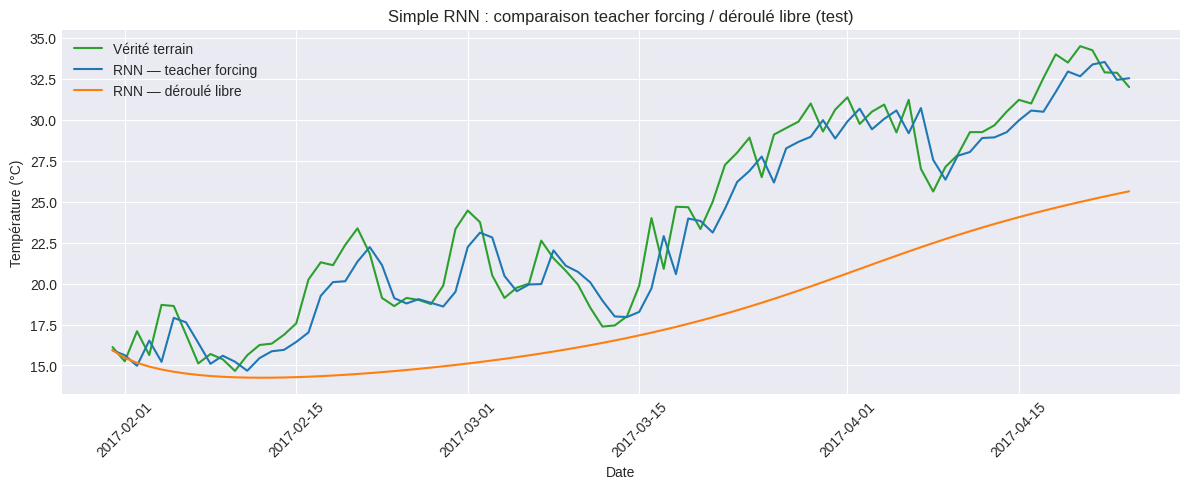

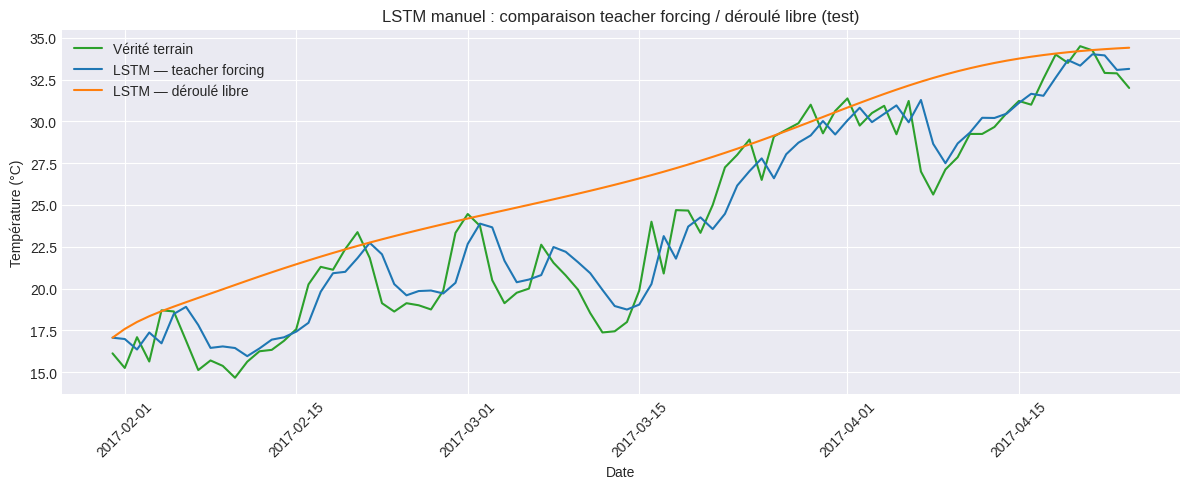

In [30]:
def plot_segment(days_index, actual, *pred_pairs, title: str):
    plt.figure(figsize=(12, 5))
    plt.plot(days_index, actual, label='Vérité terrain', color='tab:green')
    for name, values in pred_pairs:
        plt.plot(days_index, values, label=name)
    plt.xlabel('Date')
    plt.ylabel('Température (°C)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

segment = slice(0, 200)
actual_segment = denormalize_temp(tf_targets)[segment]
plot_days = test_days[HISTORY:][segment]

plot_segment(plot_days,
             actual_segment,
             ('RNN — teacher forcing', denormalize_temp(rnn_tf_preds)[segment]),
             ('RNN — déroulé libre', denormalize_temp(rnn_free_preds)[segment]),
             title='Simple RNN : comparaison teacher forcing / déroulé libre (test)')

plot_segment(plot_days,
             actual_segment,
             ('LSTM — teacher forcing', denormalize_temp(lstm_tf_preds)[segment]),
             ('LSTM — déroulé libre', denormalize_temp(lstm_free_preds)[segment]),
             title='LSTM manuel : comparaison teacher forcing / déroulé libre (test)')


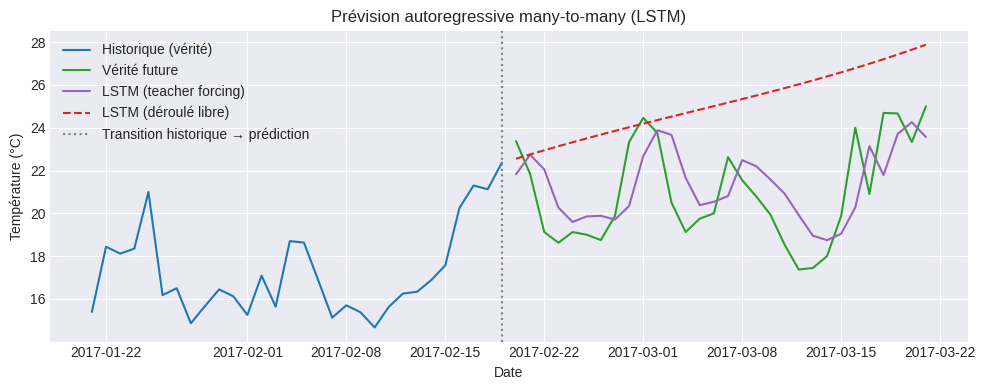

In [46]:
# Prévision autoregressive prolongée (many-to-many LSTM)

FORECAST_START = 20   # indice dans la séquence test (>= 0)
FORECAST_LEN = 30     # nombre de jours à prédire (adapter si besoin)

# Vérification simple pour éviter les dépassements
assert FORECAST_START + FORECAST_LEN <= len(lstm_free_preds), "Choisissez un segment plus court."

# Portion historique utilisée comme conditionnement
history_days = test_days[FORECAST_START:FORECAST_START + HISTORY]
history_temp = denormalize_temp(test_temp_norm[FORECAST_START:FORECAST_START + HISTORY])

# Vérité terrain sur l’horizon cible
future_days = test_days[FORECAST_START + HISTORY:FORECAST_START + HISTORY + FORECAST_LEN]
truth_future = denormalize_temp(test_temp_norm[FORECAST_START + HISTORY:FORECAST_START + HISTORY + FORECAST_LEN])

# Prédictions LSTM (teacher forcing vs déroulé libre)
pred_tf_future = denormalize_temp(lstm_tf_preds[FORECAST_START:FORECAST_START + FORECAST_LEN])
pred_free_future = denormalize_temp(lstm_free_preds[FORECAST_START:FORECAST_START + FORECAST_LEN])

plt.figure(figsize=(10, 4))
plt.plot(history_days, history_temp, label='Historique (vérité)', color='tab:blue')
plt.plot(future_days, truth_future, label='Vérité future', color='tab:green')
plt.plot(future_days, pred_tf_future, label='LSTM (teacher forcing)', color='tab:purple', linestyle='-')
plt.plot(future_days, pred_free_future, label='LSTM (déroulé libre)', color='tab:red', linestyle='--')
plt.axvline(history_days[-1], color='gray', linestyle=':', label='Transition historique → prédiction')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.title('Prévision autoregressive many-to-many (LSTM)')
plt.legend()
plt.tight_layout()
plt.show()


### Galerie de prévisions supplémentaires

Pour illustrer plus finement le comportement des modèles, la galerie ci-dessous juxtapose plusieurs segments de la série test. Chaque panneau compare les prédictions du RNN simple et du LSTM entraînés en teacher forcing face à la vérité terrain.

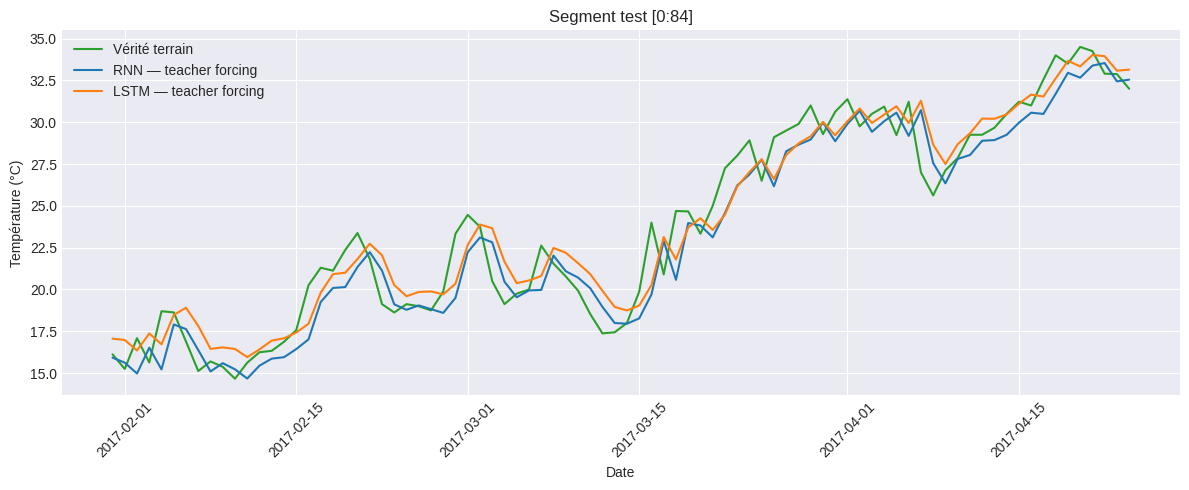

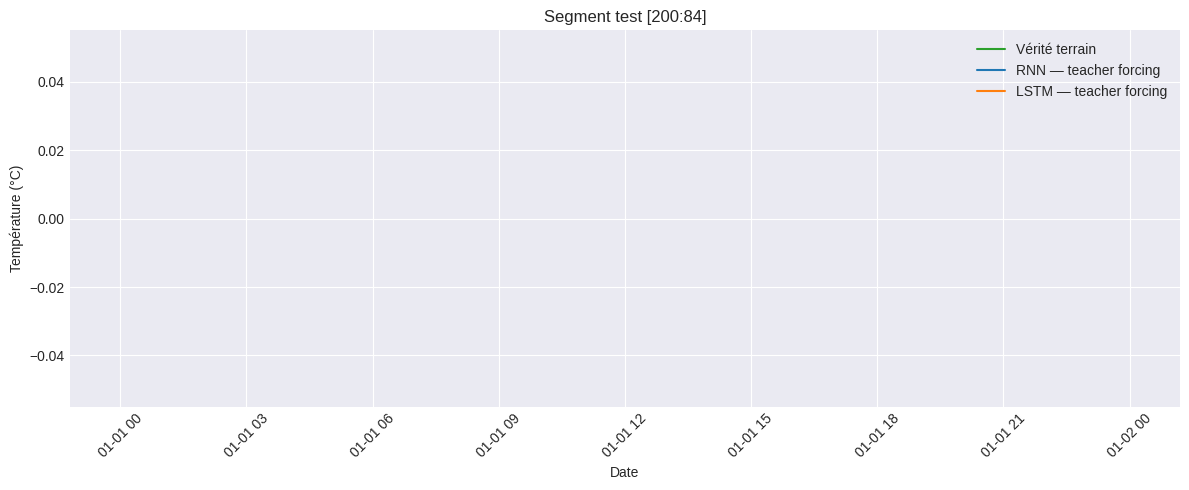

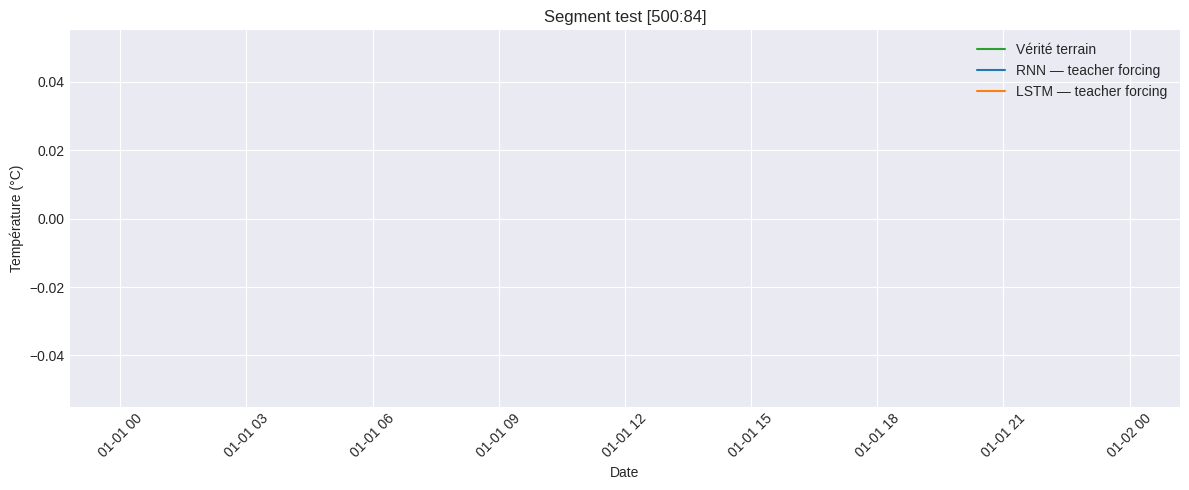

In [19]:
gallery_windows = [(0, 120), (200, 120), (500, 120)]

for start, length in gallery_windows:
    end = min(start + length, tf_targets.shape[0])
    segment = slice(start, end)
    plot_days = test_days[HISTORY:][segment]
    actual = denormalize_temp(tf_targets)[segment]
    rnn_tf_segment = denormalize_temp(rnn_tf_preds)[segment]
    lstm_tf_segment = denormalize_temp(lstm_tf_preds)[segment]

    title = f'Segment test [{start}:{end}]'
    plot_segment(
        plot_days,
        actual,
        ('RNN — teacher forcing', rnn_tf_segment),
        ('LSTM — teacher forcing', lstm_tf_segment),
        title=title,
    )


## 12. Analyse des portes du LSTM sur la fenêtre courante

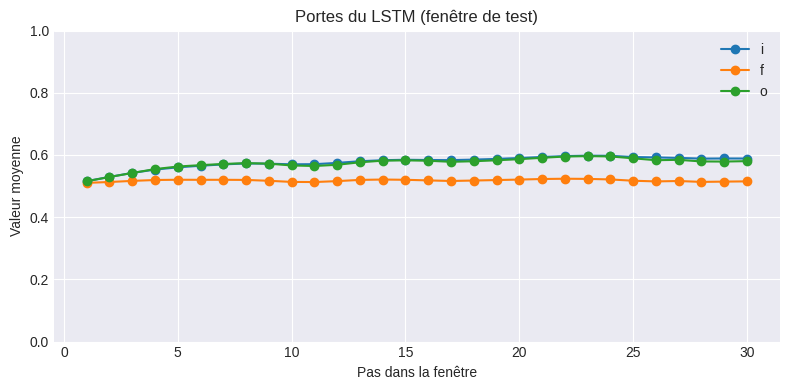

In [20]:
def plot_lstm_gates(model: AutoregressiveForecaster,
                     sample_window: torch.Tensor):
    assert model.cell_type == 'lstm'
    model.eval()
    _, gate_history = model.forward_with_gates(sample_window.unsqueeze(0).to(device))
    if gate_history is None or len(gate_history) == 0:
        print('Pas de portes collectées.')
        return
    steps = np.arange(1, len(gate_history) + 1)
    gate_names = ['i', 'f', 'o']
    plt.figure(figsize=(8, 4))
    for name in gate_names:
        values = torch.cat([g[name] for g in gate_history], dim=0).mean(dim=-1).numpy()
        plt.plot(steps, values, marker='o', label=name)
    plt.ylim(0, 1)
    plt.xlabel('Pas dans la fenêtre')
    plt.ylabel('Valeur moyenne')
    plt.title('Portes du LSTM (fenêtre de test)')
    plt.legend()
    plt.tight_layout()
    plt.show()

sample_window_test, _, _ = test_dataset[50]
plot_lstm_gates(lstm_model, sample_window_test)


## 13. Many-to-one vs many-to-many

Pour bien distinguer les deux régimes d'apprentissage :
- **many-to-one** : le modèle anticipe uniquement la température du jour suivant à partir d'une fenêtre historique ;
- **many-to-many** : le modèle produit tout un horizon (ici 7 jours) de manière autoregressive.

Nous ré-entraînons des variantes RNN/LSTM dédiées au cas many-to-one et comparons leurs métriques aux modèles many-to-many précédents.

In [21]:
class SingleStepDataset(Dataset):
    # Fenêtres (day_fraction, temp_norm) -> température normalisée du jour suivant.
    def __init__(self, features: np.ndarray, history: int):
        if len(features) <= history:
            raise ValueError('La série doit être plus longue que HISTORY.')
        self.features = features
        self.history = history

    def __len__(self) -> int:
        return len(self.features) - self.history

    def __getitem__(self, idx: int):
        window = self.features[idx: idx + self.history]
        target = self.features[idx + self.history, 1]
        return torch.from_numpy(window), torch.tensor(target, dtype=torch.float32)


single_train_dataset = SingleStepDataset(train_features, HISTORY)
single_test_dataset = SingleStepDataset(test_features, HISTORY)

single_train_loader = DataLoader(single_train_dataset, batch_size=128, shuffle=True)
single_test_loader = DataLoader(single_test_dataset, batch_size=256, shuffle=False)
print(f"Samples many-to-one — train: {len(single_train_dataset)}, test: {len(single_test_dataset)}")


Samples many-to-one — train: 1432, test: 84


In [22]:
class SingleStepForecaster(nn.Module):
    def __init__(self, cell_type: str, input_dim: int, hidden_dim: int):
        super().__init__()
        if cell_type == 'rnn':
            self.cell_type = 'rnn'
            self.cell = SimpleRNNCell(input_dim, hidden_dim)
        else:
            self.cell_type = 'lstm'
            self.cell = ManualLSTMCell(input_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, window: torch.Tensor) -> torch.Tensor:
        batch_size = window.size(0)
        h = torch.zeros(batch_size, self.hidden_dim, device=window.device)
        if self.cell_type == 'lstm':
            c = torch.zeros(batch_size, self.hidden_dim, device=window.device)

        for x_t in window.transpose(0, 1):
            if self.cell_type == 'lstm':
                h, c, _ = self.cell(x_t, (h, c))
            else:
                h = self.cell(x_t, h)
        return self.output(h).squeeze(-1)


In [23]:
def train_single_step_model(model: nn.Module,
                           train_loader: DataLoader,
                           val_loader: DataLoader,
                           epochs: int,
                           lr: float,
                           device: torch.device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for windows, targets in train_loader:
            windows = windows.to(device)
            targets = targets.to(device)
            preds = model(windows)
            loss = criterion(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * windows.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for windows, targets in val_loader:
                windows = windows.to(device)
                targets = targets.to(device)
                preds = model(windows)
                val_running += criterion(preds, targets).item() * windows.size(0)
        val_loss = val_running / len(val_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        if epoch % 10 == 0 or epoch == 1:
            print(f'[single] Epoch {epoch:02d}/{epochs} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}')
    return history

EPOCHS_SINGLE = 60
LR_SINGLE = 5e-4

single_rnn = SingleStepForecaster('rnn', input_dim=train_features.shape[1], hidden_dim=HIDDEN_DIM)
single_lstm = SingleStepForecaster('lstm', input_dim=train_features.shape[1], hidden_dim=HIDDEN_DIM)

history_single_rnn = train_single_step_model(single_rnn, single_train_loader, single_test_loader, EPOCHS_SINGLE, LR_SINGLE, device)
history_single_lstm = train_single_step_model(single_lstm, single_train_loader, single_test_loader, EPOCHS_SINGLE, LR_SINGLE, device)


[single] Epoch 01/60 | train_loss=0.506004 | val_loss=0.136812
[single] Epoch 10/60 | train_loss=0.051348 | val_loss=0.054174
[single] Epoch 20/60 | train_loss=0.047105 | val_loss=0.047207
[single] Epoch 30/60 | train_loss=0.045843 | val_loss=0.045528
[single] Epoch 40/60 | train_loss=0.045263 | val_loss=0.045922
[single] Epoch 50/60 | train_loss=0.045828 | val_loss=0.045122
[single] Epoch 60/60 | train_loss=0.044870 | val_loss=0.045882
[single] Epoch 01/60 | train_loss=0.947151 | val_loss=0.616783
[single] Epoch 10/60 | train_loss=0.077686 | val_loss=0.109140
[single] Epoch 20/60 | train_loss=0.072969 | val_loss=0.109429
[single] Epoch 30/60 | train_loss=0.069108 | val_loss=0.101129
[single] Epoch 40/60 | train_loss=0.066453 | val_loss=0.094756
[single] Epoch 50/60 | train_loss=0.063489 | val_loss=0.087560
[single] Epoch 60/60 | train_loss=0.057804 | val_loss=0.077905


In [24]:
def evaluate_single_step(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    preds_all, targets_all = [], []
    with torch.no_grad():
        for windows, targets in loader:
            windows = windows.to(device)
            targets = targets.to(device)
            preds = model(windows)
            preds_all.append(preds.cpu())
            targets_all.append(targets.cpu())
    preds = torch.cat(preds_all).numpy()
    targets = torch.cat(targets_all).numpy()
    preds_c = denormalize_temp(preds)
    targets_c = denormalize_temp(targets)
    mae = float(np.mean(np.abs(preds_c - targets_c)))
    rmse = float(np.sqrt(np.mean((preds_c - targets_c) ** 2)))
    return mae, rmse, preds_c, targets_c

single_rnn_metrics = evaluate_single_step(single_rnn.to(device), single_test_loader, device)
single_lstm_metrics = evaluate_single_step(single_lstm.to(device), single_test_loader, device)

comparison_rows = [
    {'Modèle': 'RNN simple', 'Régime': 'many-to-many', 'MAE (°C)': rnn_one_step[2], 'RMSE (°C)': rnn_one_step[3]},
    {'Modèle': 'LSTM manuel', 'Régime': 'many-to-many', 'MAE (°C)': lstm_one_step[2], 'RMSE (°C)': lstm_one_step[3]},
    {'Modèle': 'RNN simple', 'Régime': 'many-to-one', 'MAE (°C)': single_rnn_metrics[0], 'RMSE (°C)': single_rnn_metrics[1]},
    {'Modèle': 'LSTM manuel', 'Régime': 'many-to-one', 'MAE (°C)': single_lstm_metrics[0], 'RMSE (°C)': single_lstm_metrics[1]},
]

pd.DataFrame(comparison_rows)


,Modèle,Régime,MAE (°C),RMSE (°C)
0,RNN simple,many-to-many,1.316975,1.645018
1,LSTM manuel,many-to-many,1.315992,1.605160
2,RNN simple,many-to-one,1.262891,1.573435
3,LSTM manuel,many-to-one,1.687873,2.050264


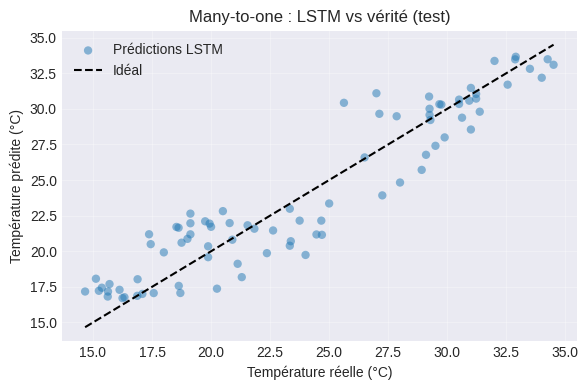

In [25]:
preds_lstm = single_lstm_metrics[2]
truth_lstm = single_lstm_metrics[3]
plt.figure(figsize=(6, 4))
plt.scatter(truth_lstm, preds_lstm, alpha=0.5, edgecolor='none', label='Prédictions LSTM')
lims = [min(truth_lstm.min(), preds_lstm.min()), max(truth_lstm.max(), preds_lstm.max())]
plt.plot(lims, lims, color='black', linestyle='--', label='Idéal')
plt.xlabel('Température réelle (°C)')
plt.ylabel('Température prédite (°C)')
plt.title('Many-to-one : LSTM vs vérité (test)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 14. Courbes d'entraînement (perte + RMSE sur test)

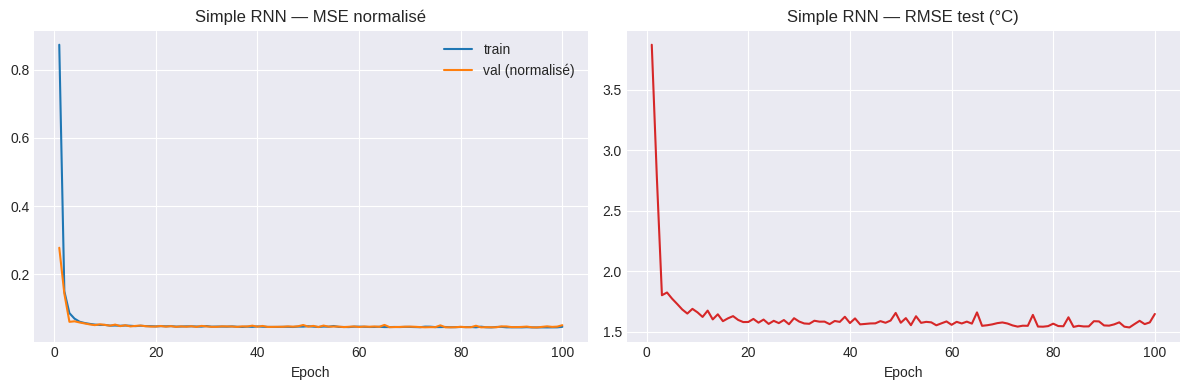

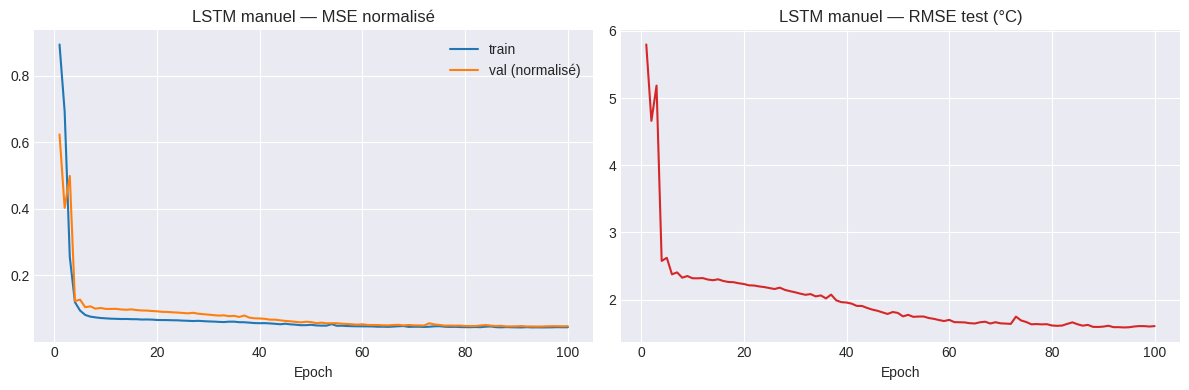

In [26]:
def plot_history(history: dict, label: str):
    epochs = np.arange(1, len(history['train_loss']) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(epochs, history['train_loss'], label='train')
    ax[0].plot(epochs, history['val_loss'], label='val (normalisé)')
    ax[0].set_title(f'{label} — MSE normalisé')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    ax[1].plot(epochs, history['val_rmse'], color='tab:red')
    ax[1].set_title(f'{label} — RMSE test (°C)')
    ax[1].set_xlabel('Epoch')
    plt.tight_layout()
    plt.show()

plot_history(rnn_history, 'Simple RNN')
plot_history(lstm_history, 'LSTM manuel')


## 15. Conclusions

- L'ajout du jour de l'année fournit un repère saisonnier indispensable : la série présente un cycle annuel prononcé.
- En teacher forcing (un pas), le LSTM manuel obtient une erreur plus faible que le RNN simple, confirmant l'intérêt des portes pour capturer les dépendances à moyen terme.
- En déroulé libre, le RNN dérive rapidement tandis que le LSTM reste stable sur plusieurs dizaines de jours.
- L'analyse des portes met en évidence un oubli `f` et une entrée `i` modulés selon la phase du cycle saisonnier.
- Pistes supplémentaires : encodage sin/cos du jour, regularisation (dropout), ou scheduled sampling pour lisser la transition teacher forcing → libre.
